In [63]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from shapely.geometry import LineString, MultiLineString, box

In [35]:
transmission_lines_path = Path.cwd().parent.parent / 'data' / 'raw' / 'brasil' / 'infraestrutura_eletrica' / 'linha_transmissao.geojson'
transmission_lines = gpd.read_file(transmission_lines_path)
transmission_lines.columns = transmission_lines.columns.str.lower()

datacenters_path = Path.cwd().parent.parent / 'data' / 'processed' / 'brasil' / 'processed_datacentermap.csv'
datacenters = pd.read_csv(datacenters_path)
datacenters.replace("", np.nan, inplace=True)

# Convert datacenters to GeoDataFrame
gdf_datacenters = gpd.GeoDataFrame(
    datacenters, 
    geometry=gpd.points_from_xy(datacenters["longitude"], datacenters["latitude"]),
    crs="EPSG:4326"
)

In [60]:
substations_path = Path.cwd().parent.parent / 'data' / 'raw' / 'brasil' / 'infraestrutura_eletrica' / 'subestacao.geojson'
substations = gpd.read_file(substations_path)
substations.dropna(subset=['INS_ID'], inplace=True)

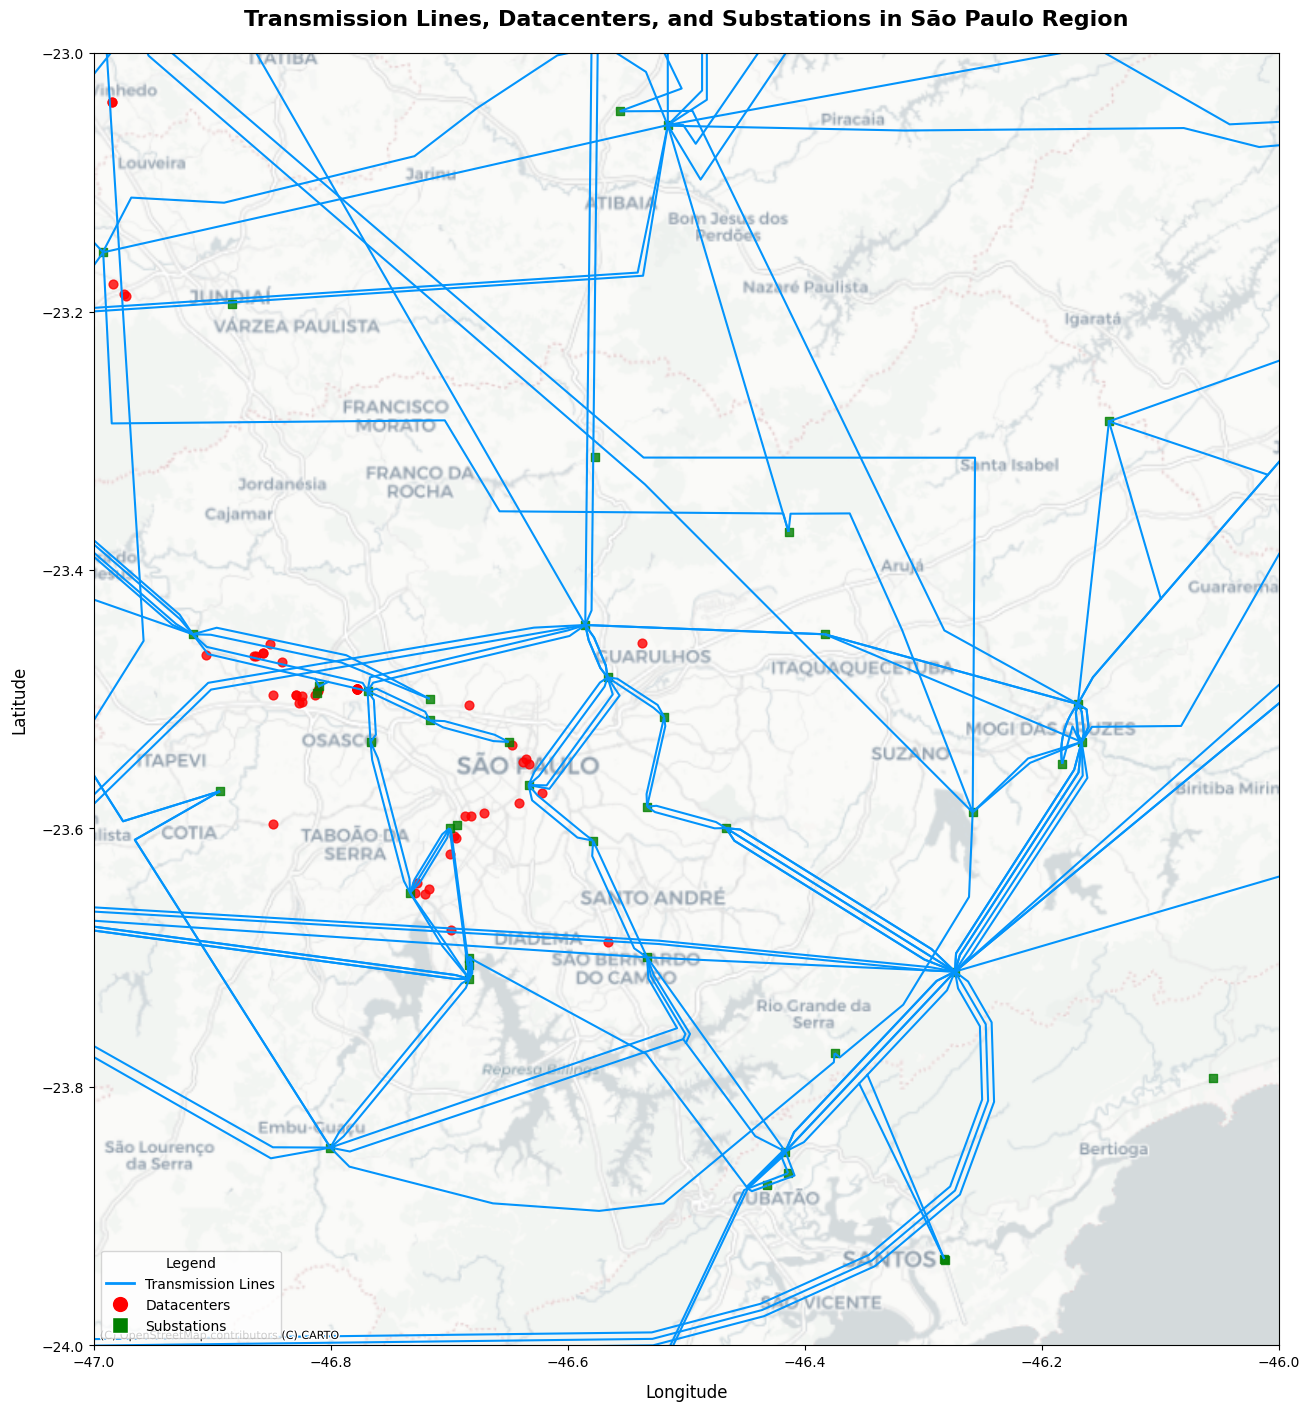

In [65]:
# Define a bounding box for a region in São Paulo (example values)
sao_paulo_bbox = {
    "minx": -47.0,
    "maxx": -46.0,
    "miny": -24.0,
    "maxy": -23.0
}

# Create a bounding box polygon from the dictionary
bbox_poly = box(sao_paulo_bbox["minx"], sao_paulo_bbox["miny"],
                sao_paulo_bbox["maxx"], sao_paulo_bbox["maxy"])

# ✅ Filter transmission lines using spatial intersection with the bbox polygon
transmission_lines_filtered = transmission_lines[transmission_lines.geometry.intersects(bbox_poly)]

# ✅ Filter datacenters based on whether their point geometry lies within the bbox polygon
gdf_datacenters_filtered = gdf_datacenters[gdf_datacenters.geometry.intersects(bbox_poly)]

# ✅ Filter substations similarly
gdf_substations_filtered = substations[substations.geometry.intersects(bbox_poly)]

# ✅ Create the plot
fig, ax = plt.subplots(figsize=(14, 14), constrained_layout=True)

# Plot Transmission Lines (blue lines)
for idx, row in transmission_lines_filtered.iterrows():
    geom = row.geometry
    if isinstance(geom, LineString):
        x, y = geom.xy
        ax.plot(x, y, color="#0394fc", linewidth=1.5)
    elif isinstance(geom, MultiLineString):
        for segment in geom.geoms:
            x, y = segment.xy
            ax.plot(x, y, color="#0394fc", linewidth=1.5)

# Plot Datacenters as red circles
gdf_datacenters_filtered.plot(ax=ax, color="red", markersize=40, label="Datacenters", alpha=0.8)

# Plot Substations as green squares
gdf_substations_filtered.plot(ax=ax, color="green", markersize=30, marker="s", label="Substations", alpha=0.8)

# Set the plot extent to the bounding box
ax.set_xlim(sao_paulo_bbox["minx"], sao_paulo_bbox["maxx"])
ax.set_ylim(sao_paulo_bbox["miny"], sao_paulo_bbox["maxy"])

# Add a basemap (using CartoDB Positron style)
ctx.add_basemap(ax, crs=gdf_datacenters_filtered.crs, source=ctx.providers.CartoDB.Positron)

# Format the plot
ax.set_title("Transmission Lines, Datacenters, and Substations in São Paulo Region", 
             fontsize=16, pad=20, weight="bold")
ax.set_xlabel("Longitude", fontsize=12, labelpad=10)
ax.set_ylabel("Latitude", fontsize=12, labelpad=10)

# Create a custom legend
legend_elements = [
    mlines.Line2D([], [], color="#0394fc", linewidth=2, label="Transmission Lines"),
    mlines.Line2D([], [], marker='o', color='red', markeredgecolor='white',
                  markersize=12, linestyle='None', label="Datacenters"),
    mlines.Line2D([], [], marker='s', color='green', markeredgecolor='white',
                  markersize=12, linestyle='None', label="Substations")
]
ax.legend(handles=legend_elements, loc="lower left", fontsize=10, title="Legend", frameon=True)

# Show the map
plt.show()


In [82]:
transmission_lines['voltage'] = transmission_lines.nomelongo.str.extract(r'(\d+)').astype(float)

In [84]:
transmission_lines.voltage.value_counts()

voltage
230.0    1382
500.0     564
345.0     227
525.0     133
440.0      88
138.0      38
765.0       9
88.0        8
34.0        4
69.0        2
Name: count, dtype: int64